# Bank Marketing Campaign - Opening a Term Deposit

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, precision_recall_curve, roc_curve, auc
from sklearn import tree

from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.figure_factory as ff
import plotly.graph_objs as go

import chart_studio.plotly as py

## Loading dataset

In [2]:
#import and printing heading
df = pd.read_csv('bank-full.csv', sep=';')
#this line causes pdays -1 value to be ignored to see how the model changes
#df = df[df['pdays'] != -1]
print(df.head())

   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  


## Exploratory data analysis - entry data

In [ ]:
df.columns

In [ ]:
print("printing basic data:\n", df.describe())
print("\nchecking if data is null:\n", df.isnull().sum())

In [ ]:
print("Num of term subscriptions")
df['y'].value_counts()

In [ ]:
train_percentage = 0.8
val_percentage = 0.1
test_percentage = 0.1

train_data, temp_data = train_test_split(df, test_size=(1 - train_percentage), random_state=42)
val_test_percentage = val_percentage / (val_percentage + test_percentage)
val_data, test_data = train_test_split(temp_data, test_size=val_test_percentage, random_state=42)

print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")
print(f"Validation set size: {len(val_data)}")

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

avg_duration = df['duration'].mean()

df["duration_status"] = np.nan
df["duration_status"] = df["duration_status"].astype(object)

lst = [df]

for col in lst:
    col.loc[col["duration"] < avg_duration, "duration_status"] = "below_average"
    col.loc[col["duration"] > avg_duration, "duration_status"] = "above_average"

pct_term = pd.crosstab(df['duration_status'], df['y']).apply(lambda r: round(r/r.sum(), 2) * 100, axis=1)

ax = pct_term.plot(kind='bar', stacked=False, cmap='RdBu')
plt.title("The Impact of Duration \n in Opening a Term Deposit", fontsize=18)
plt.xlabel("Duration Status", fontsize=18)
plt.ylabel("Percentage (%)", fontsize=18)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height() * 1.02),
                ha='center', va='center')

plt.show()

## Exploratory data analysis

In [ ]:
# column_names = ['age', 'job', 'marital', 'education', 'housing', 'loan', 'y']

# for name in column_names:
#    value_counts = df[name].value_counts()
    
#    value_counts_df = value_counts.reset_index()
#    value_counts_df.columns = [name, 'Counts']
    
#    plt.figure(figsize=(15, 10))
#    sns.barplot(x=name, y='Counts', data=value_counts_df)
    
#    plt.title(f'Count of {name}')
#    plt.xlabel('Values')
#    plt.ylabel('Counts')
    
#    plt.show()

In [ ]:
colors = ["#3399ff", "#ffcc00"]
palette = ["#3399ff", "#ffcc00"]

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

plt.suptitle('Information on Term Subscriptions', fontsize=20)

df["y"].value_counts().plot.pie(
    explode=[0, 0.25],
    autopct='%1.2f%%',
    ax=ax[0],
    shadow=True,
    colors=colors,
    fontsize=12,
    startangle=25
)
ax[0].set_title('State of Loan', fontsize=16)
ax[0].set_ylabel('% of Condition of Loans', fontsize=14)

sns.barplot(
    x="education",
    y="balance",
    hue="y",
    data=df,
    palette=palette,
    estimator=lambda x: len(x) / len(df) * 100,
    ax=ax[1]
)
ax[1].set_ylabel("(%)")
education_labels = df["education"].unique()
ax[1].set_xticks(range(len(education_labels)))
ax[1].set_xticklabels(education_labels, rotation=0, rotation_mode="anchor")

plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

df.hist(bins=20, figsize=(14,10), color='#E14906')
plt.show()

In [ ]:
fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)

# First plot
g = sns.boxplot(x="default", y="balance", hue="y", data=df, palette="muted", ax=ax1)
g.set_title("Amount of Balance by Term Subscriptions")

# Second plot
g1 = sns.boxplot(x="job", y="balance", hue="y", data=df, palette="RdBu", ax=ax2)
job_labels = df["job"].unique()
job_positions = range(len(job_labels))
g1.set_xticks(job_positions)
g1.set_xticklabels(job_labels, rotation=90, rotation_mode="anchor")
g1.set_title("Type of Work by Term Subscriptions")

# Third plot
g2 = sns.violinplot(data=df, x="education", y="balance", hue="y", palette="RdBu_r", ax=ax3)
g2.set_title("Distribution of Balance by Education")

plt.show()

In [ ]:
import squarify
import random

df = df.drop(df.loc[df["balance"] == 0].index)

x = 0
y = 0
width = 100
height = 100

job_names = df['job'].value_counts().index
values = df['job'].value_counts().tolist()

normed = squarify.normalize_sizes(values, width, height)
rects = squarify.squarify(normed, x, y, width, height)

colors = ['rgb(200, 255, 144)','rgb(135, 206, 235)',
          'rgb(235, 164, 135)','rgb(220, 208, 255)',
          'rgb(253, 253, 150)','rgb(255, 127, 80)', 
          'rgb(218, 156, 133)', 'rgb(245, 92, 76)',
          'rgb(252, 64, 68)', 'rgb(154, 123, 91)']

random.shuffle(colors)

shapes = []
annotations = []
counter = 0

for r in rects:
    shapes.append(
        dict(
            type = 'rect',
            x0 = r['x'],
            y0 = r['y'],
            x1 = r['x'] + r['dx'],
            y1 = r['y'] + r['dy'],
            line = dict(width=2),
            fillcolor = colors[counter]
        )
    )
    annotations.append(
        dict(
            x = r['x']+(r['dx']/2),
            y = r['y']+(r['dy']/2),
            text = values[counter],
            showarrow = False
        )
    )
    counter = counter + 1
    if counter >= len(colors):
        counter = 0
    
# For hover text
trace0 = go.Scatter(
    x = [ r['x']+(r['dx']/2) for r in rects],
    y = [ r['y']+(r['dy']/2) for r in rects],
    text = [ str(v) for v in job_names],
    mode='text',
)

layout = dict(
    title='Number of Occupations',
    height=700, 
    width=700,
    xaxis=dict(showgrid=False,zeroline=False),
    yaxis=dict(showgrid=False,zeroline=False),
    shapes=shapes,
    annotations=annotations,
    hovermode='closest'
)

# With hovertext
figure = dict(data=[trace0], layout=layout)

iplot(figure, filename='squarify-treemap')

In [ ]:
fig = ff.create_facet_grid(
    df,
    x='duration',
    y='balance',
    color_name='marital',
    show_boxes=False,
    marker={'size': 10, 'opacity': 1.0},
    colormap={'single': 'rgb(165, 242, 242)', 'married': 'rgb(253, 174, 216)', 'divorced': 'rgba(201, 109, 59, 0.82)'}
)

iplot(fig, filename='facet - custom colormap')

In [ ]:
fig = ff.create_facet_grid(
    df,
    y='balance',
    facet_row='marital',
    facet_col='y',
    trace_type='box',
)

iplot(fig, filename='facet - box traces')

### Correlation Matrix

In [ ]:
fig = plt.figure(figsize=(12,8))
df['y'] = LabelEncoder().fit_transform(df['y'])

numeric_df = df.select_dtypes(exclude="object")

corr_numeric = numeric_df.corr()

sns.heatmap(corr_numeric, cbar=True, cmap="RdBu_r")
plt.title("Correlation Matrix", fontsize=16)
plt.show()

### Pair Plot

In [ ]:
sns.pairplot(df, hue='y')
plt.show()

## Logical Regression Model

In [19]:
lr_df = pd.read_csv('bank-full.csv', sep=';')

categorical_columns = lr_df.select_dtypes(include=['object']).columns
label_encoders = {}

for column in categorical_columns:
    le = LabelEncoder()
    lr_df[column] = le.fit_transform(lr_df[column])
    label_encoders[column] = le

X = lr_df.drop('y', axis=1)
y = lr_df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear', C=1.0)
time_start = time.time()
lr.fit(X_train, y_train)
time_end = time.time()
lr_time = time_end - time_start

y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy score: {:.2f}%".format(100 * accuracy))
print("Precision score: {:.2f}%".format(100 * precision))
print("Recall score: {:.2f}%".format(100 * recall))

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94      7952
           1       0.59      0.21      0.31      1091

    accuracy                           0.89      9043
   macro avg       0.75      0.60      0.62      9043
weighted avg       0.86      0.89      0.86      9043

Accuracy score: 88.74%
Precision score: 59.43%
Recall score: 21.08%


In [20]:
lr_train_score = lr.score(X_train, y_train)

print(f"Training Score for Logistic Regression: {lr_train_score:.4f}")
print(f"Training Time for Logistic Regression: {lr_time:.2f} s")

log_scores = cross_val_score(lr, X_train, y_train, cv=3)
lr_log_reg_mean = log_scores.mean()

print(f"Crossval Mean Score for Logistic Regression: {lr_log_reg_mean:.4f}")

Training Score for Logistic Regression: 0.8920
Training Time for Logistic Regression: 0.54 s
Crossval Mean Score for Logistic Regression: 0.8916


### Performance Metrics for Logistic Regression

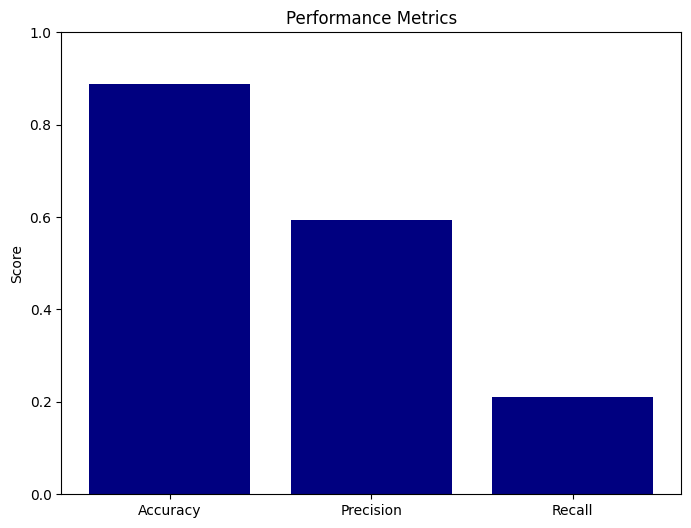

In [21]:
categories = ['Accuracy', 'Precision', 'Recall']
values = [accuracy, precision, recall]

plt.figure(figsize=(8, 6))
plt.bar(categories, values, color='navy')
plt.title('Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

### Confusion Matrix for Logistic Regression Model

Confusion Matrix:
[[7795  157]
 [ 861  230]]


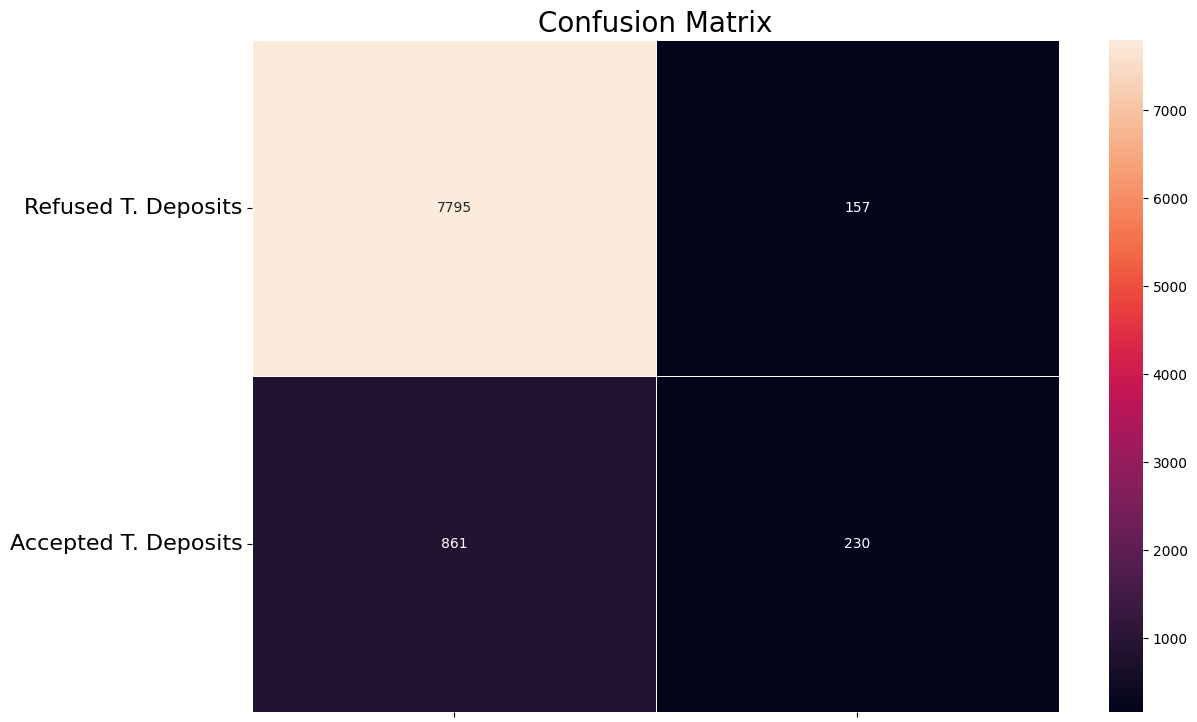

In [22]:
conf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.title("Confusion Matrix", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels("")
ax.set_yticklabels(['Refused T. Deposits', 'Accepted T. Deposits'], fontsize=16, rotation=360)

print(f"Confusion Matrix:\n{conf_matrix}")

### ROC Curve for Logistic Regression Model

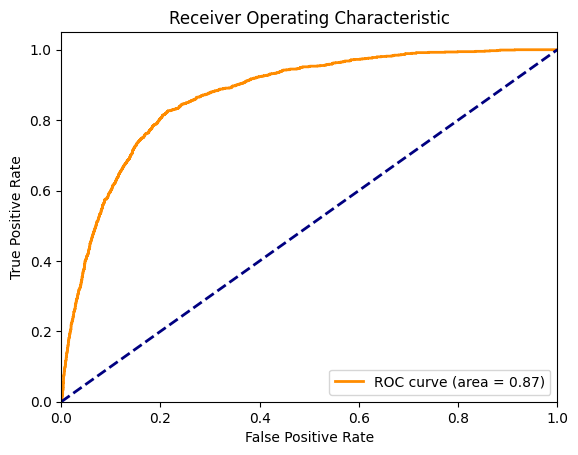

In [23]:
y_pred_proba = lr.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


### Precision-Recall Curve for Decision Tree

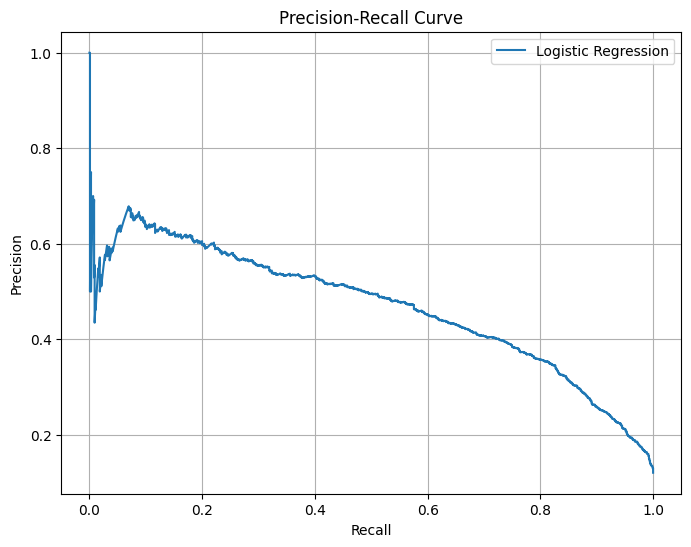

In [24]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, label="Precision-Recall Curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

## Decision Tree

In [7]:
dt_df = pd.read_csv('bank-full.csv', sep=';')

categorical_columns = dt_df.select_dtypes(include=['object']).columns
label_encoders = {}

for column in categorical_columns:
    le = LabelEncoder()
    dt_df[column] = le.fit_transform(dt_df[column])
    label_encoders[column] = le

X = dt_df.drop('y', axis=1)
y = dt_df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt = DecisionTreeClassifier(random_state=42)
time_start = time.time()
dt.fit(X_train, y_train)
time_end = time.time()
dt_time = time_end - time_start

y_pred = dt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy score: {:.2f}%".format(100 * accuracy))
print("Precision score: {:.2f}%".format(100 * precision))
print("Recall score: {:.2f}%".format(100 * recall))

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      7952
           1       0.48      0.48      0.48      1091

    accuracy                           0.87      9043
   macro avg       0.70      0.70      0.70      9043
weighted avg       0.87      0.87      0.87      9043

Accuracy score: 87.40%
Precision score: 47.82%
Recall score: 48.21%


In [8]:
dt_train_score = dt.score(X_train, y_train)

print(f"Training Score for Deicion Tree: {dt_train_score:.4f}")
print(f"Training Time for Deicion Tree: {dt_time:.2f} s")

log_scores = cross_val_score(dt, X_train, y_train, cv=3)
dt_log_reg_mean = log_scores.mean()

print(f"Crossval Mean Score for Deicion Tree: {dt_log_reg_mean:.4f}")

Training Score for Deicion Tree: 1.0000
Training Time for Deicion Tree: 0.22 s
Crossval Mean Score for Deicion Tree: 0.8740


### Performance Metrics for Decision Tree

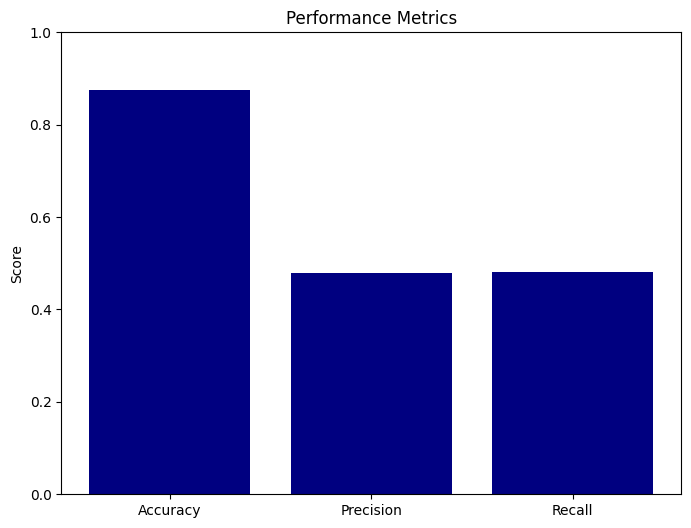

In [9]:
categories = ['Accuracy', 'Precision', 'Recall']
values = [accuracy, precision, recall]

plt.figure(figsize=(8, 6))
plt.bar(categories, values, color='navy')
plt.title('Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

### Confusion Matrix for Decision Tree Classifier

Confusion Matrix:
[[7378  574]
 [ 565  526]]


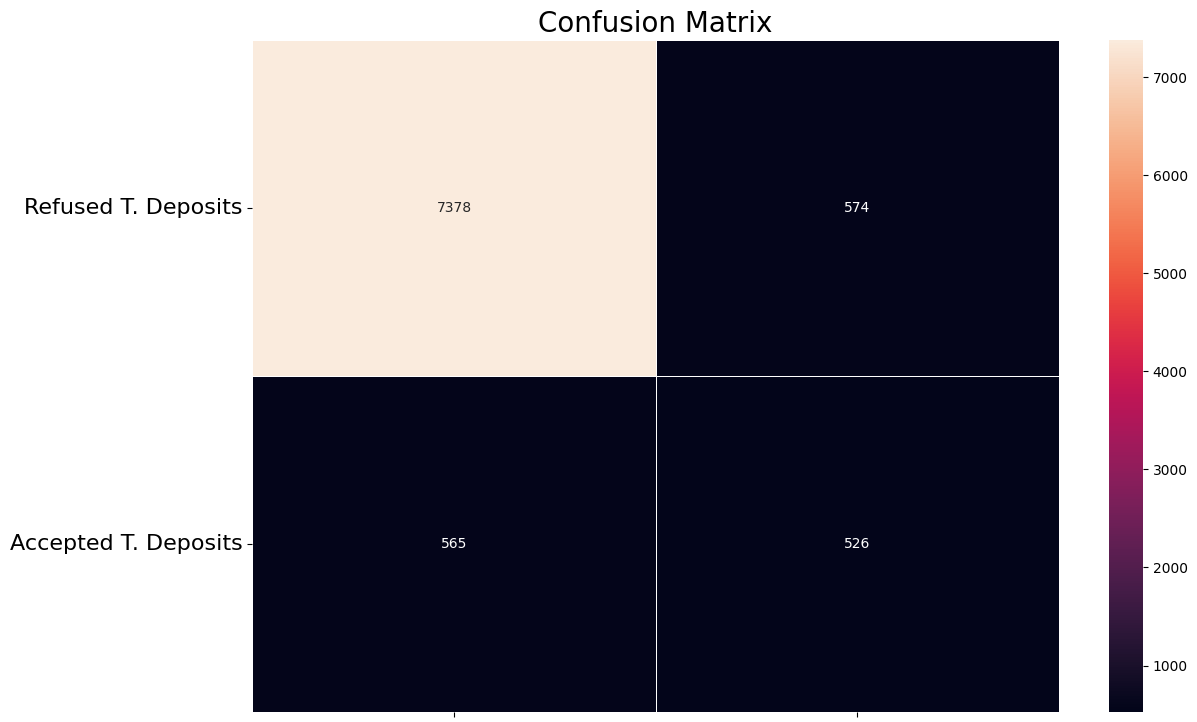

In [10]:
conf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.title("Confusion Matrix", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels("")
ax.set_yticklabels(['Refused T. Deposits', 'Accepted T. Deposits'], fontsize=16, rotation=360)

print(f"Confusion Matrix:\n{conf_matrix}")

### ROC Curve for Decision Tree Classifier

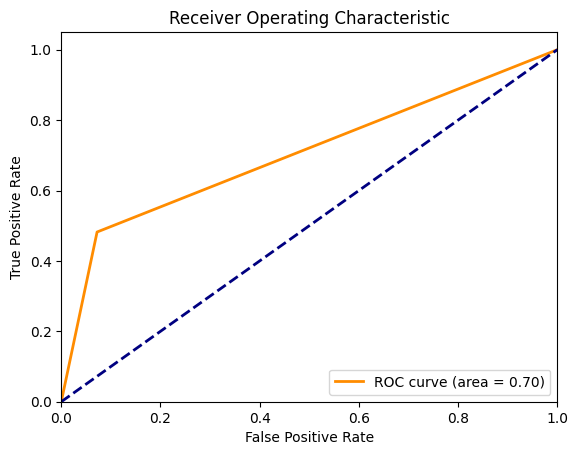

In [11]:
y_pred_proba = dt.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Precision-Recall Curve for Decision Tree

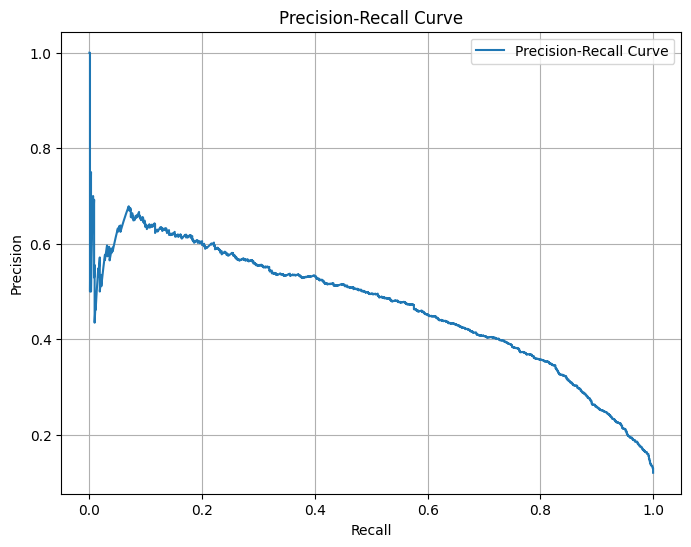

In [25]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, label="Precision-Recall Curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

### Generated Decision Tree

In [ ]:
plt.figure(figsize=(20, 10))
tree.plot_tree(dt, feature_names=X.columns, class_names=['no', 'yes'], filled=True)
plt.title('Decision Tree for Bank Marketing Campaign')
plt.show()

### Most important features for Decision Tree

In [41]:
importances = dt.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

print("Top 10 Important Features:")
print(feature_importances.head(10))

Top 10 Important Features:
     feature  importance
11  duration    0.294289
5    balance    0.110755
0        age    0.104776
10     month    0.103624
9        day    0.083587
13     pdays    0.054215
15  poutcome    0.049498
1        job    0.048486
12  campaign    0.034509
6    housing    0.024067


## Classification Model

In [ ]:
term_deposits = df.copy()
dep = term_deposits['y']
term_deposits.drop(labels=['y'], axis=1,inplace=True)
term_deposits.insert(0, 'y', dep)
term_deposits.head()

term_deposits["housing"].value_counts()/len(term_deposits)

In [ ]:
term_deposits["loan"].value_counts() / len(term_deposits)

## Data preparation

In [ ]:
X = df.drop('y', axis=1)
y = df['y']

#normalization dumb data
X = pd.get_dummies(X)

#split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#data normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
grad_clf    = GradientBoostingClassifier()
grad_scores = cross_val_score(grad_clf, X_train, y_train, cv=3)
grad_mean   = grad_scores.mean()

grad_clf.fit(X_train, y_train)

y_train_pred = cross_val_predict(grad_clf, X_train, y_train, cv=3)
print("Gradient Boost Classifier accuracy: {:.2f}%".format(100 * accuracy_score(y_train, y_train_pred)))

## Modeling with MLPClassifier

In [ ]:
model = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)
model.fit(X_train, y_train)

predictions = model.predict(X_test)

## Modeling with Gradient Boost Classifier

In [ ]:
# Gradient Boosting Classifier
grad_clf    = GradientBoostingClassifier()
grad_scores = cross_val_score(grad_clf, X_train, y_train, cv=3)
grad_mean   = grad_scores.mean()

y_train_pred = cross_val_predict(grad_clf, X_train, y_train, cv=3)
grad_clf.fit(X_train, y_train)
print ("Gradient Boost Classifier accuracy: {:.2f}%".format(100 * accuracy_score(y_train, y_train_pred)))

## Model evaluation

In [ ]:
print("confusion_matrix:\n", confusion_matrix(y_test, predictions))
print("classification_report:\n", classification_report(y_test, predictions))
print("Accuracy: {:.2f}%".format(100 * accuracy_score(y_test, predictions)))

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, threshold = precision_recall_curve(y_train, y_scores)

In [ ]:
from sklearn.metrics import roc_curve
# Gradient Boosting Classifier
grd_fpr, grd_tpr, thresold = roc_curve(y_train, y_scores)

In [ ]:
some_instance = X_train[1250]
y_scores = grad_clf.decision_function([some_instance])
y_scores
y_scores = cross_val_predict(grad_clf, X_train, y_train, cv=3, method="decision_function")

In [ ]:
def graph_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.figure(figsize=(10,6))
    plt.plot(false_positive_rate, true_positive_rate, label=label)
    plt.plot([0, 1], [0, 1], '#0C8EE0')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#F75118', shrink=0.05),
                )
    
    
graph_roc_curve(grd_fpr, grd_tpr, threshold)
plt.show()

## Optimization of hyperparameters

In [ ]:
# parameter_space = {
#    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
#    'activation': ['tanh', 'relu'],
#    'solver': ['sgd', 'adam'],
#    'alpha': [0.0001, 0.05],
#    'learning_rate': ['constant','adaptive'],
# }
# clf = GridSearchCV(model, parameter_space, n_jobs=-1, cv=3)
# clf.fit(X_train, y_train)
# print("Best param:", clf.best_params_)
